# Classification

In [1]:
#importando a base
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data = '../data/customer_clustered.csv'
base_clustered = pd.read_csv(data)
base_clustered.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Age,Age_Group,Mnt_Total,Mnt_Reg,Children,Has_Children,Accepted_Cmp_Total,Has_Accepted_Cmp,Num_Total_Purchases,Cluster
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,57,46-60,1617,1529,0,0,0,0,22,0
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,60,46-60,27,21,2,1,0,0,4,1
2,Graduation,Partner,71613.0,0,0,26,426,49,127,111,...,49,46-60,776,734,0,0,0,0,20,0
3,Graduation,Partner,26646.0,1,0,26,11,4,20,10,...,30,18-30,53,48,1,1,0,0,6,1
4,PhD,Partner,58293.0,1,0,94,173,43,118,46,...,33,31-45,422,407,1,1,0,0,14,2


In [2]:
#Verificando informações
base_clustered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Education             2205 non-null   object 
 1   Marital_Status        2205 non-null   object 
 2   Income                2205 non-null   float64
 3   Kidhome               2205 non-null   int64  
 4   Teenhome              2205 non-null   int64  
 5   Recency               2205 non-null   int64  
 6   MntWines              2205 non-null   int64  
 7   MntFruits             2205 non-null   int64  
 8   MntMeatProducts       2205 non-null   int64  
 9   MntFishProducts       2205 non-null   int64  
 10  MntSweetProducts      2205 non-null   int64  
 11  MntGoldProds          2205 non-null   int64  
 12  NumDealsPurchases     2205 non-null   int64  
 13  NumWebPurchases       2205 non-null   int64  
 14  NumCatalogPurchases   2205 non-null   int64  
 15  NumStorePurchases    

# Separando para treinar o modelo

In [3]:
#Separando X e Y
X= base_clustered.drop('Response',axis=1)
y=base_clustered['Response']

In [4]:
#Organizando as colunas em variaveis. 
one_hot_cols = [
    'Education',
    'Marital_Status',
    'Age_Group',
    'Kidhome',
    'Teenhome',
    'AcceptedCmp1',
    'AcceptedCmp2',
    'AcceptedCmp3',
    'AcceptedCmp4',
    'AcceptedCmp5',
    'Accepted_Cmp_Total',
    'Has_Accepted_Cmp',
    'Complain',
    'Years_Since_Enrolled',
    'Children',
    'Has_Children',
    'Cluster'
]
standart_cols=[
    'Income',
    'Age'
]
power_cols = X.columns[
    X.columns.str.startswith('Mnt') | X.columns.str.startswith('Num')
].tolist()

MinMax_cols=[
    'Days_Since_Enrolled',
    'Recency'
]

## Utilização de bibliotecas
- DummyClassifier: Classificar todos os labels como 1 único parametro 'stratified', respondendo na proporção da classificação. Como estamos tratando de um dataset desbalanceado, se algum modelo tiver uma performace pior que a dele, ele será descartado.
- Já os outro 3 modelos, DecisionTreeClassifier, LogisticRegression, KNeighborsClassifier são modelos mais faceis de explicar e que já tenho maior familiaridade.
#### Considerações epecificas:
- Muitas colunas (35)
- Dataset desbalanceado, logo utilizar o Pipeline do imblearn
- Utilizar o RandomUnderSampler para balancear os dados
- Seleciona as melhores características com base em algum critério de pontuação. 

In [5]:
#Fazendo o preprocessamento e o Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
    PowerTransformer,
)
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_validate

RANDOM_STATE = 42

models = {
    "DummyClassifier": DummyClassifier(strategy="stratified", random_state=RANDOM_STATE),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "LogisticRegression": LogisticRegression(random_state=RANDOM_STATE),
    "KNNClassifier": KNeighborsClassifier(n_neighbors=5),
}

skf =  StratifiedKFold(n_splits=5, shuffle=True,random_state=RANDOM_STATE)
def pipeline_model(X,y,model,kf):
    preprocessing = ColumnTransformer(
        [
            ('standard', StandardScaler(), standart_cols),
            ('onehot', OneHotEncoder(), one_hot_cols),
            ('power', PowerTransformer(), power_cols),
            ('minmax', MinMaxScaler(), MinMax_cols)
        ]
    )
    pipeline =  Pipeline(
        [
            ('preprocessing',preprocessing),
            ('feature_selection',SelectKBest(score_func=f_classif,k=10)),
            ('rus',RandomUnderSampler(random_state=RANDOM_STATE)),
            ('model',model)
        ]
    )
    scores= cross_validate(
        pipeline,
        X,
        y,
        cv=kf,
        scoring=['accuracy', 'precision', 'recall', 'roc_auc', 'average_precision']
    )
    return scores

In [6]:
#Criando um dicionario
results = {
    "DummyClassifier": pipeline_model(X, y, models["DummyClassifier"], skf),
    "DecisionTreeClassifier": pipeline_model(X, y, models["DecisionTreeClassifier"], skf),
    "LogisticRegression": pipeline_model(X, y, models["LogisticRegression"], skf),
    "KNNClassifier": pipeline_model(X, y, models["KNNClassifier"], skf),
}

In [7]:
#Facilitando a leitura das respostas
from pprint import pprint

pprint(results)

{'DecisionTreeClassifier': {'fit_time': array([0.06759953, 0.06859541, 0.07210898, 0.07310605, 0.0706017 ]),
                            'score_time': array([0.02804303, 0.0285542 , 0.02755022, 0.02805376, 0.02804661]),
                            'test_accuracy': array([0.82539683, 0.82993197, 0.82993197, 0.81179138, 0.68253968]),
                            'test_average_precision': array([0.3683831 , 0.38016844, 0.3602606 , 0.43117226, 0.21919691]),
                            'test_precision': array([0.43243243, 0.44444444, 0.44871795, 0.40229885, 0.25974026]),
                            'test_recall': array([0.47761194, 0.47761194, 0.52238806, 0.53030303, 0.60606061]),
                            'test_roc_auc': array([0.68534999, 0.70773805, 0.73826722, 0.71830303, 0.65264646])},
 'DummyClassifier': {'fit_time': array([0.07160735, 0.06960106, 0.07160115, 0.07159328, 0.06959581]),
                     'score_time': array([0.02905369, 0.02905011, 0.02805066, 0.02805614, 0.02905512

In [8]:
# Adicionando o tempo
for k, v in results.items():
    results[k]['time'] = results[k]['fit_time'] + results[k]['score_time']

pprint(results)


{'DecisionTreeClassifier': {'fit_time': array([0.06759953, 0.06859541, 0.07210898, 0.07310605, 0.0706017 ]),
                            'score_time': array([0.02804303, 0.0285542 , 0.02755022, 0.02805376, 0.02804661]),
                            'test_accuracy': array([0.82539683, 0.82993197, 0.82993197, 0.81179138, 0.68253968]),
                            'test_average_precision': array([0.3683831 , 0.38016844, 0.3602606 , 0.43117226, 0.21919691]),
                            'test_precision': array([0.43243243, 0.44444444, 0.44871795, 0.40229885, 0.25974026]),
                            'test_recall': array([0.47761194, 0.47761194, 0.52238806, 0.53030303, 0.60606061]),
                            'test_roc_auc': array([0.68534999, 0.70773805, 0.73826722, 0.71830303, 0.65264646]),
                            'time': array([0.09564257, 0.09714961, 0.0996592 , 0.10115981, 0.09864831])},
 'DummyClassifier': {'fit_time': array([0.07160735, 0.06960106, 0.07160115, 0.07159328, 0.0695958

In [9]:
#Criando um dataframe apartir do dicionario
base_results = pd.DataFrame(results).T.reset_index().rename(columns={"index": "model"})
base_results

,model,fit_time,score_time,test_accuracy,test_precision,test_recall,test_roc_auc,test_average_precision,time
0,DummyClassifier,"[0.07160735130310059, 0.06960105895996094, 0.0...","[0.029053688049316406, 0.029050111770629883, 0...","[0.5124716553287982, 0.5034013605442177, 0.503...","[0.1542056074766355, 0.14485981308411214, 0.14...","[0.4925373134328358, 0.4626865671641791, 0.462...","[0.5042900470907494, 0.4866908771649773, 0.486...","[0.15304952129175473, 0.14865734269715697, 0.1...","[0.10066103935241699, 0.09865117073059082, 0.0..."
1,DecisionTreeClassifier,"[0.06759953498840332, 0.06859540939331055, 0.0...","[0.028043031692504883, 0.028554201126098633, 0...","[0.8253968253968254, 0.8299319727891157, 0.829...","[0.43243243243243246, 0.4444444444444444, 0.44...","[0.47761194029850745, 0.47761194029850745, 0.5...","[0.6853499880277755, 0.7077380477292681, 0.738...","[0.3683830979533475, 0.38016844076749257, 0.36...","[0.0956425666809082, 0.09714961051940918, 0.09..."
2,LogisticRegression,"[0.07562112808227539, 0.07613301277160645, 0.0...","[0.029063701629638672, 0.028046131134033203, 0...","[0.7845804988662132, 0.8299319727891157, 0.829...","[0.35106382978723405, 0.4444444444444444, 0.45...","[0.4925373134328358, 0.47761194029850745, 0.53...","[0.6850307287093942, 0.7018716577540107, 0.738...","[0.3819814120613085, 0.41413493126523665, 0.36...","[0.10468482971191406, 0.10417914390563965, 0.1..."
3,KNNClassifier,"[0.0691065788269043, 0.07110929489135742, 0.07...","[0.05558419227600098, 0.05307626724243164, 0.0...","[0.8662131519274376, 0.8662131519274376, 0.854...","[0.7857142857142857, 0.7222222222222222, 0.565...","[0.16417910447761194, 0.19402985074626866, 0.1...","[0.5843642748822732, 0.5984515923058504, 0.606...","[0.2649084509425661, 0.3041475401367669, 0.252...","[0.12469077110290527, 0.12418556213378906, 0.1..."


In [10]:
base_results.columns[1:].to_list()

['fit_time',
 'score_time',
 'test_accuracy',
 'test_precision',
 'test_recall',
 'test_roc_auc',
 'test_average_precision',
 'time']

In [11]:
#Retirar as informações de 'Array' 
base_results_explode = base_results.explode(
    base_results.columns[1:].to_list()
).reset_index(drop=True)

base_results_explode

,model,fit_time,score_time,test_accuracy,test_precision,test_recall,test_roc_auc,test_average_precision,time
0,DummyClassifier,0.071607,0.029054,0.512472,0.154206,0.492537,0.50429,0.15305,0.100661
1,DummyClassifier,0.069601,0.02905,0.503401,0.14486,0.462687,0.486691,0.148657,0.098651
2,DummyClassifier,0.071601,0.028051,0.503401,0.14486,0.462687,0.486691,0.148657,0.099652
3,DummyClassifier,0.071593,0.028056,0.487528,0.126168,0.409091,0.455212,0.14005,0.099649
4,DummyClassifier,0.069596,0.029055,0.510204,0.149533,0.484848,0.499758,0.149598,0.098651
5,DecisionTreeClassifier,0.0676,0.028043,0.825397,0.432432,0.477612,0.68535,0.368383,0.095643
6,DecisionTreeClassifier,0.068595,0.028554,0.829932,0.444444,0.477612,0.707738,0.380168,0.09715
7,DecisionTreeClassifier,0.072109,0.02755,0.829932,0.448718,0.522388,0.738267,0.360261,0.099659
8,DecisionTreeClassifier,0.073106,0.028054,0.811791,0.402299,0.530303,0.718303,0.431172,0.10116
9,DecisionTreeClassifier,0.070602,0.028047,0.68254,0.25974,0.606061,0.652646,0.219197,0.098648


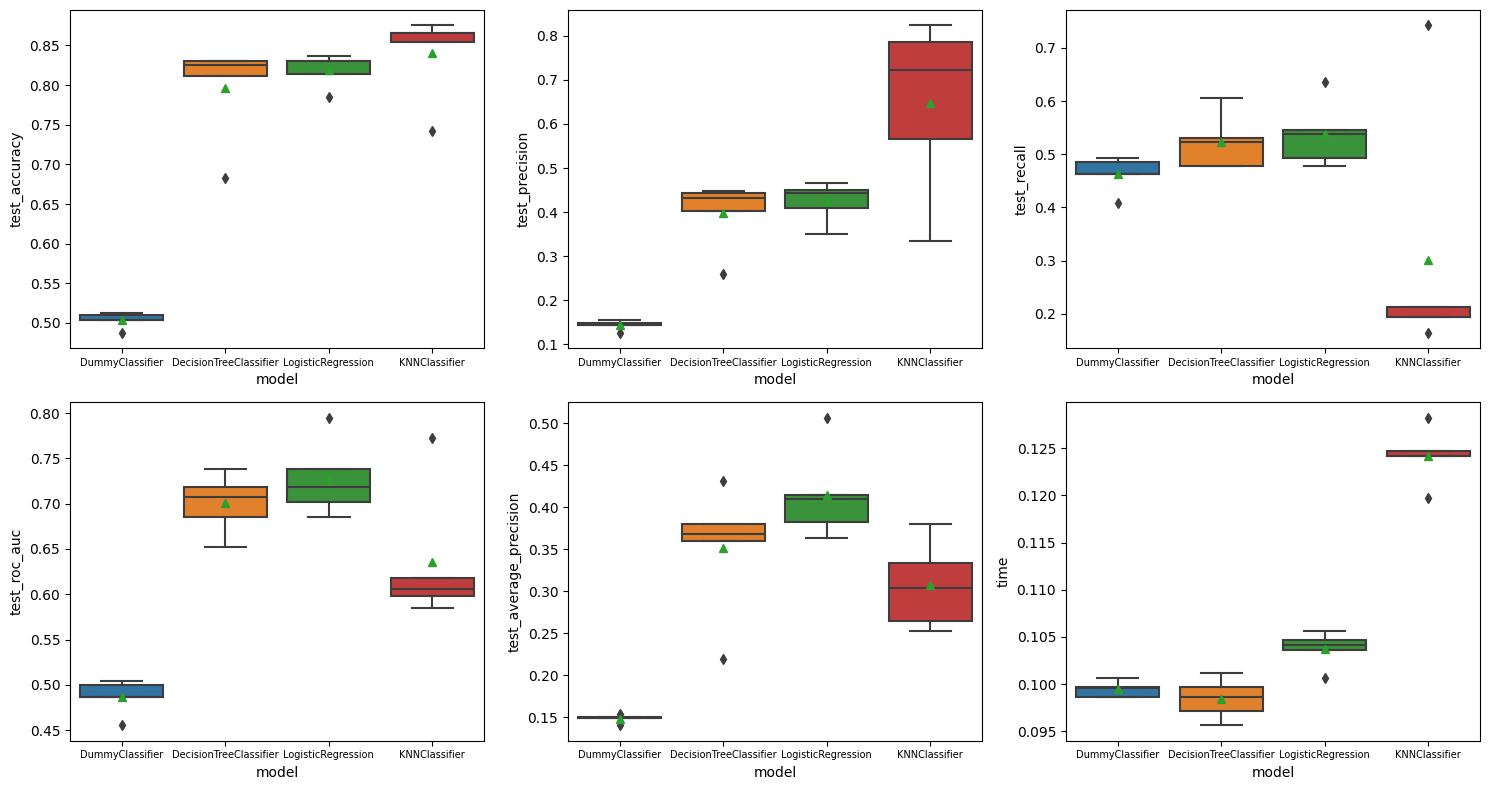

In [12]:
#Coloando o 'base_results_explode' em forma gráfica
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), tight_layout=True)

cols = base_results.columns[3:].to_list()

for ax, col in zip(axs.flatten(), cols):
    b = sns.boxplot(x="model", y=col, data=base_results_explode, ax=ax, showmeans=True)
    b.set_xticklabels(b.get_xticklabels(), fontsize=7)

plt.show()

## Considerações:
- O KNN é melhor se utilizarmos: Accuracy, Precision, e bem pior se utilizarmos o Recal.
- DecisionTree e Logistic Regression tem bons padrões bem parecidos em todas as metricas.
- Em questão do tempo, o KNN é o modelo que mais demora, enquanto (excluindo o Dummy), o Logistic Regression é o que teve a melhor performace.
- Em dataset desbalanceados, uma boa metrica para ser avaliada é a Average_Precision e o ROC_AUC.
- De 6 métricas, o Logistic Regression ganha em 4, dentre eles os 2 principais.
#### Após as avaliações, iremos tentar melhorar o modelo Logistic Regression com hiperparametros.